# Assignment 5 Solution

This assignment is collaborated by **Jingting Dai** and **Hongjie Guan**. **Hongjie finished A05.1 and Jingting finished A05.2 and A05.3** 

## A05.1 Everyday networks are not Poisson: parameter estimation and model selection

Task: For all given networks compute the degree
distribution 𝑃(𝑘) and the average degree ⟨𝑘⟩ and use the
powerlaw package to fit 𝑃(𝑘).

### 1. Compute the power-law exponent 𝛾 of the degree distribution 𝑃(𝑘) ∼ 𝑘−𝛾 and the corresponding error

In [86]:
import networkx as nx
import scipy.stats as sp
from scipy.special import factorial
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import powerlaw
import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams['figure.figsize'] = (12, 6)

In [2]:
def import_datasets(datasets_folder):
    d={} #empty dictionary
    for item in os.listdir(datasets_folder):
        if 'gml'in item and 'random' not in item:
            item_path = os.path.join(datasets_folder,item)
            item_name = item.split("_",1)[1].split(".")[0] 
            print("dataset named "+item_name+" imported")
            d["{}".format(item_name)] = nx.read_gml(item_path)
    print("finish importing")
    return d

In [3]:
graphs = import_datasets('data-assignment5')
graphs

dataset named amazon imported
dataset named escort imported
dataset named internet imported
finish importing


{'amazon': <networkx.classes.graph.Graph at 0x21b89cf4310>,
 'escort': <networkx.classes.graph.Graph at 0x21b88342a30>,
 'internet': <networkx.classes.graph.Graph at 0x21be9ee1880>}

In [33]:
# compute degree distribution
def compute_degree_distribution(graphs:dict)->dict:
    dd={}
    for k,v in graphs.items():
        degress = v.degree()
        dd[k]=[ degress[i] for i in v.nodes() ]
    return dd
 
    
# compute average degree<k>
def compute_average_degree(degree_distribution:dict)->dict:
    avg_ks={}
    for k,v in degree_distribution.items():
        avg_k = sum(v)/len(v)
        avg_ks[k]=avg_k
    return avg_ks

In [38]:
degree_distribution = compute_degree_distribution(graphs)
avg_ks = compute_average_degree(degree_distribution)
print("The average degree <k> of the given graphs are:")
avg_ks

The average degree <k> of the given graphs are:


{'amazon': 5.529855493141971,
 'escort': 4.667543335325762,
 'internet': 6.197750352406432}

In [54]:
def compute_gamma_and_error(degree_distribution:dict)->dict:
    gamma_and_error={}
    for k,v in degree_distribution.items():
        result = powerlaw.Fit(np.sort(np.asarray(v)))
        gamma = result.power_law.alpha
        sigma = result.power_law.sigma
        gamma_and_error[k]=(gamma,sigma)
    return gamma_and_error

gamma_and_error=compute_gamma_and_error(degree_distribution)
print("\nThe (gamma. sigma) tuples for each of the datasets are:")
gamma_and_error

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
xmin progress: 99%
The (gamma. sigma) tuples for each of the datasets are:


{'amazon': (4.065660034466614, 0.09699319113242895),
 'escort': (2.9544249080995764, 0.07919729392592209),
 'internet': (2.112191339113011, 0.0366878070312722)}

### 2. In the same plot show: the empirical degree distribution; the power-law fit; the Poisson fit and the exponential distribution with mean value equal to ⟨𝑘⟩. Which distribution is more likely to describe the data?


In [121]:
def plot_data_with_multiple_fit(degree_distribution:dict,dataset_name:str,scale:str):
    k_list=degree_distribution[dataset_name]
    # plot empirical data
    l=len(k_list)
    k_unique=np.unique(np.asarray(k_list))
    P_k = [k_list.count(k)/l for k in k_unique]
    plt.scatter(k_unique,P_k,s=4,label="empirical")
    # plot powerlaw fit
    k_list = np.sort(np.array(degree_distribution[dataset_name]))
    result = powerlaw.Fit(k_list,xmin=min(k_list))
    powerlaw.plot_pdf(k_list,color='b',marker="o",label="empirical[2]")
    result.power_law.plot_pdf(color='r',label="power-law")

    
    # compute <k> as lamda
    lamda = sum(degree_distribution[dataset_name])/len(degree_distribution[dataset_name])
    
    # plot exponential distribution
    P_k_possion=[(pow(lamda,k)/factorial(k))*np.exp(-lamda) for k in k_unique]
    plt.plot(k_unique,P_k_possion,color='green',label="Poisson")
    # plot exponential distribution
    P_k_possion=[(np.exp(-(k/lamda))/lamda) for k in k_unique]
    plt.plot(k_unique,P_k_possion,color='yellow',label="exponential")
    
    plt.xscale(scale)
    plt.yscale(scale)
    plt.ylim([0.001*min(P_k), 1.5*max(P_k)])
    plt.xlabel('k')
    plt.ylabel('P(k)')
    plt.legend(loc='best')
    plt.title("Degree distribution of {}".format(dataset_name))

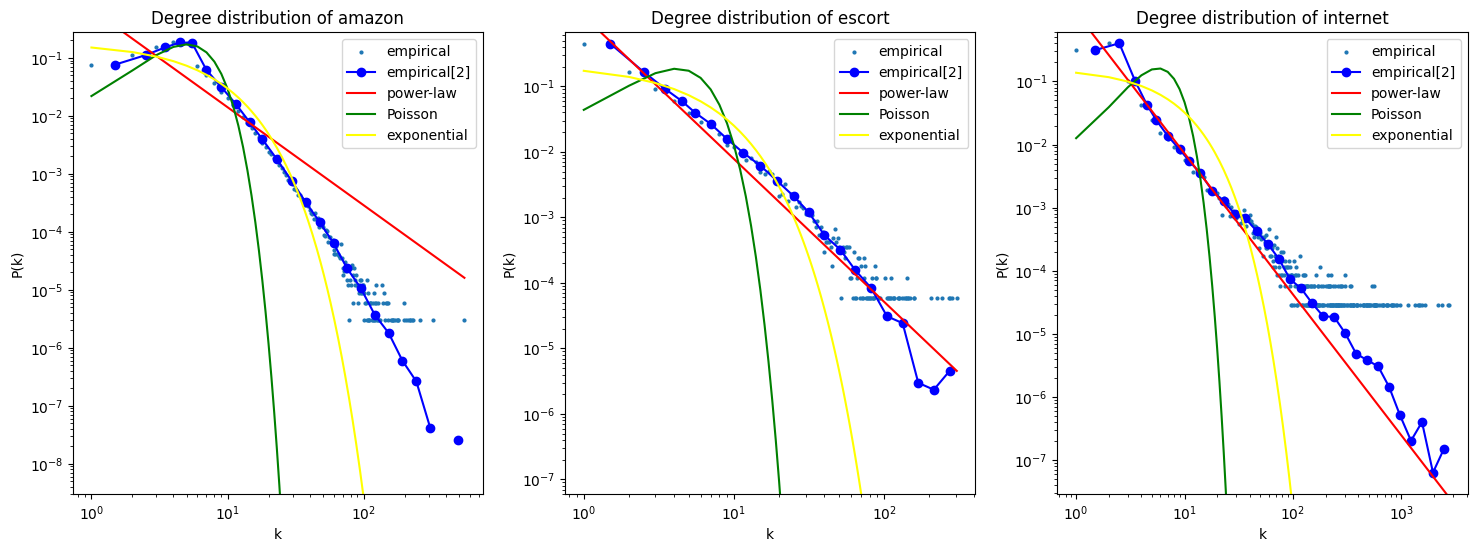

The empirical[2] distribution is generated by the powerlaw library.


In [122]:
matplotlib.rcParams['figure.figsize'] = (18, 6)
plt.subplot(1, 3, 1)
plot_data_with_multiple_fit(degree_distribution,'amazon','log')
plt.subplot(1, 3, 2)
plot_data_with_multiple_fit(degree_distribution,'escort','log')
plt.subplot(1, 3, 3)
plot_data_with_multiple_fit(degree_distribution,'internet','log')

plt.show()
print("The empirical[2] distribution is generated by the powerlaw library.")

We can tell that, obviously, the power-law can fit the best. The slope of the line is very close to the slope of distribution.

### 3. What does it mean in practice for Amazon products?

The distribution of co-sale products of Amazon are close to but not totally scale-free. If the distribution is scale-free(fit best by power law distritbution), it means that there is no pivot or the mean of co-sales where other co-sales number hover around(or the standard error is very large), which means that those Amazon products that sales with a lots of other products are really rare and those products that seldom sold with other products are very common.
However, we found that around $k=10^{0.7}$, the P(k) appreas to be maximized.This shows that there are some products that co-saled by $10^{0.7}$ other products, are more prequently pruchased. Amazon could look into these products.

## A05.2 Barabási-Albert model

Task: Build networks with the Barabási-Albert model.Connect 𝑚 = 3 for each new node and grow until 𝑁 = 50, 100, 500, 1000, 5000.

### 1. Compute the average clustering coefficient, assortativity, average shortest path length and diameter for the generated networks

### 2. Produce randomised versions of the same networks and calculate the same quantities, then plot them as functions of 𝑁 and compare with the non-randomised ones (use log x axis)

### 3. Which of these measures is relatively unchanged by randomisation? Why? A5: Scale-Free Networks | 2. A05.2 Preferential Attachment mo

## A05.3 Barabási-Albert model (2)


Task: Build networks of 𝑁 = 500 nodes with the BA model,
varying the number of new connections 𝑚 ∈ {2, 3, 4, 5}.

### 1. Plot the degree distributions of the resulting networks

### 2. Estimate the power-law fit parameters

### 3. Plot the power-law exponent 𝛼 as a function of 𝑚